In [1]:
import numpy as np
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# BST-based MaxHeapItem replacement
class BSTManager:
    def __init__(self):
        self.bst = SortedDict()  # BST to store (value, indices) pairs
        self.index_to_value = {}  # Dictionary to map indices to their values

    def add_item(self, value, indices):
        if value not in self.bst:
            self.bst[value] = []
        self.bst[value].append(indices)  # Add indices to the value's list
        self.index_to_value[indices] = value  # Update index-to-value mapping

    def delete_item(self, indices):
        if indices in self.index_to_value:
            value = self.index_to_value[indices]
            self.bst[value].remove(indices)  # Remove indices from the value's list
            if not self.bst[value]:  # If the list is empty, remove the value from the BST
                del self.bst[value]
            del self.index_to_value[indices]  # Remove from index-to-value mapping

    def pop_largest(self):
        if not self.bst:
            return None  # BST is empty
        largest_value = self.bst.keys()[-1]  # Get the largest value
        indices = self.bst[largest_value].pop(0)  # Remove the first indices with this value
        if not self.bst[largest_value]:  # If the list is empty, remove the value from the BST
            del self.bst[largest_value]
        del self.index_to_value[indices]  # Remove from index-to-value mapping
        return largest_value, indices

    def update_item(self, indices, new_value):
        self.delete_item(indices)  # Remove the old value
        self.add_item(new_value, indices)  # Add the new value

In [3]:
# Simulation functions
def change_spin_at(i, j, k, state):
    spins[i, j, k] = state
    if state == 1:
        bst_manager.delete_item((i, j, k))

def change_field_at(i, j, k, delF):
    if spins[i, j, k] == -1:
        old_value = local_fields[i, j, k]
        new_value = old_value + delF
        bst_manager.update_item((i, j, k), new_value)
        local_fields[i, j, k] = new_value

def flip(i, j, k, queue, avl, time):
    i, j, k = i % N, j % N, k % N
    change_spin_at(i, j, k, state=1)
    avalanches[i, j, k] = avl
    times[i, j, k] = time

    neighbours = [
        [(i + 1) % N, j, k], [(i - 1) % N, j, k],
        [i, (j + 1) % N, k], [i, (j - 1) % N, k],
        [i, j, (k + 1) % N], [i, j, (k - 1) % N]
    ]
    for neighbour in neighbours:
        if spins[neighbour[0], neighbour[1], neighbour[2]] == -1:
            change_field_at(neighbour[0], neighbour[1], neighbour[2], 2 * J)
            queue.append((neighbour[0], neighbour[1], neighbour[2]))

def avalanche_statistics(avalanches_array, times_array):
    max_avalanche_id = int(np.max(avalanches_array))
    avalanche_sizes = np.zeros(max_avalanche_id + 1, dtype=np.int64)
    avalanche_start_times = np.zeros(max_avalanche_id + 1, dtype=np.int64)
    avalanche_end_times = np.zeros(max_avalanche_id + 1, dtype=np.int64)

    for avalanche_id, flip_time in zip(avalanches_array.flat, times_array.flat):
        if avalanche_id == 0:
            continue
        if avalanche_sizes[avalanche_id] == 0:
            avalanche_start_times[avalanche_id] = flip_time
            avalanche_end_times[avalanche_id] = flip_time
        avalanche_start_times[avalanche_id] = min(avalanche_start_times[avalanche_id], flip_time)
        avalanche_end_times[avalanche_id] = max(avalanche_end_times[avalanche_id], flip_time)
        avalanche_sizes[avalanche_id] += 1

    avalanche_sizes = avalanche_sizes[1:]
    avalanche_start_times = avalanche_start_times[1:]
    avalanche_end_times = avalanche_end_times[1:]
    avalanche_durations = avalanche_end_times - avalanche_start_times + 1

    return avalanche_sizes, avalanche_durations

In [4]:
#####
# ? Single sim params
####
# Initialize parameters
N = 100
J = 1
# R = 2.25

# # Initialize arrays
# spins = -np.ones((N, N, N))
# h = np.random.normal(0, R, (N, N, N))
# H = -np.max(h)
# local_fields = H + h
# avalanches = np.zeros((N, N, N), dtype = np.int32)
# times = np.zeros((N, N, N), dtype = np.int32)

# # Initialize BST manager
# bst_manager = BSTManager()
# for i in range(N):
#     for j in range(N):
#         for k in range(N):
#             bst_manager.add_item(local_fields[i, j, k], (i, j, k))

# # Simulation parameters
# spins_left = N**3
# spins_flipped = 0
# queue = []
# avl = 1
# time = 0

In [5]:
Rs = [2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
avalanches_for_different_Rs = []
times_for_different_Rs = []
magnetizations_for_different_Rs = []
Hs_for_different_Rs = []

for R in Rs:
    spins = -np.ones((N, N, N))
    h = np.random.normal(0, R, (N, N, N))
    # H = -np.max(h)
    H = -N # large negative value
    local_fields = H + h
    avalanches = np.zeros((N, N, N), dtype = np.int32)
    times = np.zeros((N, N, N), dtype = np.int32)
    magnetization = []
    H_list = []

    # Initialize BST manager
    bst_manager = BSTManager()
    for i in range(N):
        for j in range(N):
            for k in range(N):
                bst_manager.add_item(local_fields[i, j, k], (i, j, k))
    
    # Simulation parameters
    spins_left = N**3
    spins_flipped = 0
    queue = []
    avl = 1
    time = 0

    with tqdm(total=spins_left, desc=f"Processing spins: R = {R}", unit="spin") as pbar:
        while spins_left > 0:
            time += 1
            if spins_flipped == 0:
                current_item = bst_manager.pop_largest()
                if current_item is None:
                    print("BST is empty. Exiting loop.")
                    break
        
                H, (i, j, k) = current_item
                spins_flipped += 1
                spins_left -= 1
                flip(i, j, k, queue, avl, time)
                pbar.update(1)  # Update the progress bar by 1 spin
                
                M = np.mean(spins)  # Compute magnetization
                
                magnetization.append(M)
                H_list.append(-H)

            else:
                spins_flipped = 0
                new_queue = []
                for (i, j, k) in queue:
                    if local_fields[i, j, k] >= H:
                        if spins[i, j, k] == -1:
                            spins_left -= 1
                            spins_flipped += 1
                            flip(i, j, k, new_queue, avl, time)
                queue = new_queue
                if spins_flipped == 0:
                    avl += 1
        
        print("Simulation completed.")
    avalanches_for_different_Rs.append(avalanches)
    times_for_different_Rs.append(times)
    magnetizations_for_different_Rs.append(magnetization)
    Hs_for_different_Rs.append(H_list)


Processing spins: R = 2.25:   3%| | 33708/1000000 [00:23<11:11, 1438.74spin/


Simulation completed.


Processing spins: R = 2.5:   6%| | 56314/1000000 [00:27<07:41, 2046.02spin/s


Simulation completed.


Processing spins: R = 2.75:   9%| | 86715/1000000 [00:33<05:51, 2597.74spin/


Simulation completed.


Processing spins: R = 3:  12%| | 121309/1000000 [00:41<04:59, 2938.39spin/s]


Simulation completed.


Processing spins: R = 3.25:  16%|▏| 157250/1000000 [00:48<04:17, 3268.87spin


Simulation completed.


Processing spins: R = 3.5:  19%|▏| 194050/1000000 [00:54<03:45, 3573.88spin/


Simulation completed.


Processing spins: R = 3.75:  23%|▏| 227941/1000000 [00:57<03:15, 3939.57spin


Simulation completed.


Processing spins: R = 4:  26%|▎| 261455/1000000 [01:03<02:59, 4122.63spin/s]

Simulation completed.


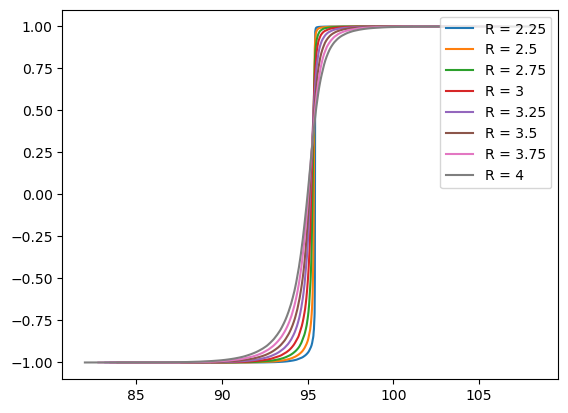

In [6]:
for idx, R in enumerate(Rs):
    plt.plot(Hs_for_different_Rs[idx], magnetizations_for_different_Rs[idx], label = f"R = {R}")
plt.legend(loc = "upper right")

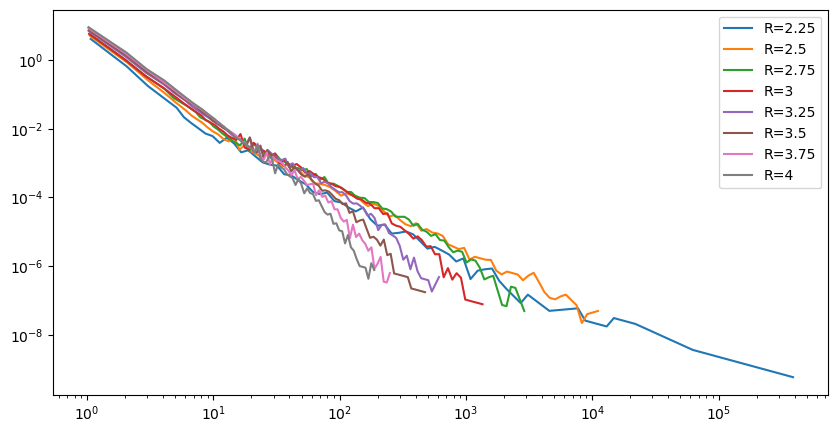

In [7]:
fig, ax = plt.subplots(figsize = (10, 5))

for idx, R in enumerate(Rs):
    avalanche_sizes, avalanche_durations = avalanche_statistics(avalanches_for_different_Rs[idx], times_for_different_Rs[idx])

    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 100), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Filter out zero values in the histogram (log(0) is undefined)
    valid_indices = hist > 0
    bin_centers = bin_centers[valid_indices]
    hist = hist[valid_indices]
    ax.plot(bin_centers, hist, linestyle = "-", label = f"R={R}")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc = "upper right")

Text(0, 0.5, '$S^\\tau D_{\\text{int}}S^{\\sigma r}$')

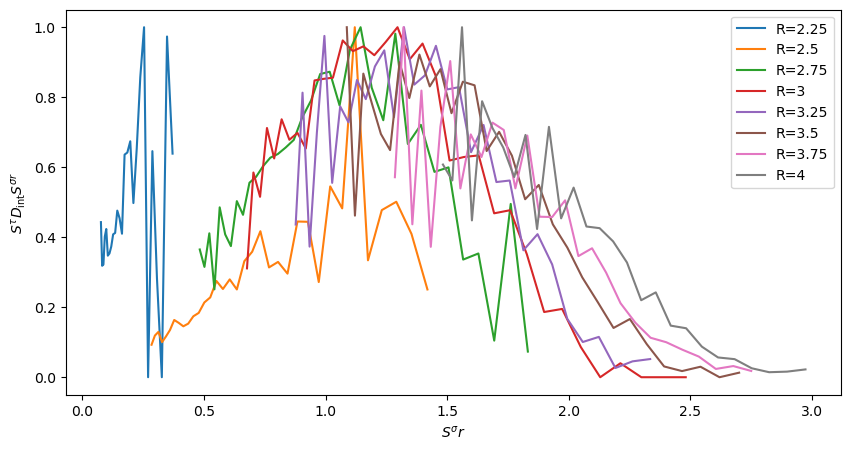

In [8]:
sigma = 0.24
tau = 2.03
Rc = 2.16

fig, ax = plt.subplots(figsize = (10, 5))

for idx, R in enumerate(Rs):
    # R = Rs[idx]
    r = (R - Rc)/Rc
    avalanche_sizes, _ = avalanche_statistics(avalanches_for_different_Rs[idx], times_for_different_Rs[idx])
    
    bin_edges = np.logspace(np.log10(min(avalanche_sizes)), np.log10(max(avalanche_sizes)), 50)
    hist, _ = np.histogram(avalanche_sizes, bins=bin_edges, density=True)
    
    S = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    mask = (S < 10**4) & (S > 10)
    S = S[mask]
    hist = hist[mask]
    
    X_scaled = S**sigma*r
    D_scaled = (S**tau)*hist
    D_scaled /= np.max(D_scaled)
    
    ax.plot(X_scaled, D_scaled, label = f"R={R}")
    # plt.xscale("log")
ax.legend(loc = "upper right")
ax.set_xlabel(r"$S^\sigma r$")
ax.set_ylabel(r"$S^\tau D_{\text{int}}S^{\sigma r}$")